In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
loans = pd.read_csv('data/lending-club-data.csv')
train_idx = pd.read_json('data/module-8-assignment-2-train-idx.json')[0]
test_idx = pd.read_json('data/module-8-assignment-2-test-idx.json')[0]
loans['safe_loans'] = loans['bad_loans'].apply(lambda x : +1 if x==0 else -1)
loans = loans.drop(columns=['bad_loans'])
features = ['grade',              # grade of the loan
            'term',               # the term of the loan
            'home_ownership',     # home ownership status: own, mortgage or rent
            'emp_length',         # number of years of employment
           ]

target = 'safe_loans'                    # prediction target (y) (+1 means safe, -1 is risky)

# Extract the feature columns and target column
loans = loans[features + [target]]
train_data = loans.iloc[train_idx]
test_data = loans.iloc[test_idx]

C:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (19,47) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [2]:
def one_hot_encoding(df, target):
    categorical_features = []
    for feature_name, feature_type in zip(df.columns, df.dtypes):
        if feature_type is np.dtype('O'):
            categorical_features.append(feature_name)
            
    for feature_name in categorical_features:
        df2 = pd.get_dummies(df[feature_name],prefix=feature_name)
        df = df.join(df2).drop([feature_name], axis=1)

    t = df[target]
    return (df.drop([target], axis=1), t)


train_data, train_target = one_hot_encoding(train_data, target)
test_data, test_target = one_hot_encoding(test_data, target)

In [30]:
def create_leaf(target_values, data_weights):    
    leaf = {'splitting_feature' : None,
            'left' : None,
            'right' : None,
            'is_leaf': True}
    
    weighted_error, best_class = intermediate_node_weighted_mistakes(target_values, data_weights)
    if best_class ==1:
        leaf['prediction'] = 1
    elif best_class == -1:
        leaf['prediction'] = -1
    
    return leaf


def evaluate_classification_error(tree, data, target):
    # Apply the classify(tree, x) to each row in your data
    prediction = data.apply(lambda x: classify(tree, x), axis=1)
    return (prediction != target).sum()/len(target)


def print_stump(tree, name = 'root'):
    split_name = tree['splitting_feature'] # split_name is something like 'term. 36 months'
    if split_name is None:
        print ("(leaf, label: %s)" % tree['prediction'])
        return None
    split_feature, split_value = split_name.split('_')
    print ('                       %s' % name)
    print ('         |---------------|----------------|')
    print ('         |                                |')
    print ('         |                                |')
    print ('         |                                |')
    print ('  [{0} == 0]               [{0} == 1]    '.format(split_name))
    print ('         |                                |')
    print ('         |                                |')
    print ('         |                                |')
    print ('    (%s)                         (%s)' \
        % (('leaf, label: ' + str(tree['left']['prediction']) if tree['left']['is_leaf'] else 'subtree'),
           ('leaf, label: ' + str(tree['right']['prediction']) if tree['right']['is_leaf'] else 'subtree')))
    

def reached_minimum_node_size(data, min_node_size):
    return True if data.shape[0] <= min_node_size else False
    

def error_reduction(error_before_split, error_after_split):
    return error_before_split-error_after_split


def count_leaves(tree):
    if tree['is_leaf']:
        return 1
    return count_leaves(tree['left']) + count_leaves(tree['right'])


def count_nodes(tree):
    if tree['is_leaf']:
        return 1
    return 1 + count_nodes(tree['left']) + count_nodes(tree['right'])

In [120]:
def weighted_error(y, y_hat, weights):
    return (y!=y_hat)*weights/weights.sum()


def intermediate_node_weighted_mistakes(labels_in_node, data_weights):
    total_weight_positive = (data_weights[labels_in_node == +1]).sum()
    
    # Weight of mistakes for predicting all -1's 
    weighted_mistakes_all_negative = total_weight_positive
    
    total_weight_negative = (data_weights[labels_in_node == -1]).sum()
    weighted_mistakes_all_positive = total_weight_negative
    
    if weighted_mistakes_all_positive > weighted_mistakes_all_negative:
        return (weighted_mistakes_all_negative, -1)
    else:
        return (weighted_mistakes_all_positive, 1)



def best_splitting_feature(data, features, target, data_weights):
    
    best_feature = None
    best_error = float('+inf') 
    num_points = float(len(data))

    for feature in features:
        filter_0 = (data[feature] == 0)
        filter_1 = (data[feature] == 1)
        left_split = data[filter_0]
        right_split = data[filter_1]
        
        left_data_weights = data_weights[filter_0]
        right_data_weights = data_weights[filter_1]
        left_target = target[filter_0]
        right_target = target[filter_1]
        left_weighted_mistakes, left_class = intermediate_node_weighted_mistakes(left_target, left_data_weights)
        right_weighted_mistakes, right_class = intermediate_node_weighted_mistakes(right_target, right_data_weights)
        
        error = (left_weighted_mistakes+right_weighted_mistakes)/num_points
        if error < best_error:
            best_feature = feature
            best_error = error
            
    # If the data is identical in each feature, this function should return None
    return best_feature


def weighted_decision_tree_create(data, features, target_values, data_weights,
                                  current_depth = 1, max_depth = 10):
    remaining_features = features[:] # Make a copy of the features.
    print("--------------------------------------------------------------------")
    print("Subtree, depth = %s (%s data points)." % (current_depth, len(target_values)))
    
    if intermediate_node_weighted_mistakes(target_values, data_weights)[0] <= 1e-15:
        print ("Stopping condition 1. Error is 0.")          
        return create_leaf(target_values, data_weights)
    
    if len(remaining_features) == 0:
        print( "Stopping condition 2. No more features.")         
        return create_leaf(target_values, data_weights)    
    
    if current_depth > max_depth:
        print ("Reached maximum depth. Stopping for now.")
        return create_leaf(target_values, data_weights)
    
    splitting_feature = best_splitting_feature(data, features, target_values, data_weights)
    # If all the datapoints are the same, splitting_feature will be None. Create a leaf
    if splitting_feature is None:
        return create_leaf(target_values, data_weights)
    remaining_features = remaining_features.drop(splitting_feature)
    
    left_split = data[data[splitting_feature] == 0]
    right_split = data[data[splitting_feature] == 1]
    left_target = target_values[data[splitting_feature] == 0]
    right_target = target_values[data[splitting_feature] == 1]
    left_data_weights = data_weights[data[splitting_feature] == 0]
    right_data_weights = data_weights[data[splitting_feature] == 1]
    
    print( "Split on feature %s. (%s, %s)" % (\
              splitting_feature, len(left_split), len(right_split)))
    
    # Create a leaf node if the split is "perfect"
    # 0 error reduction    
    if len(left_split) == len(data):
        print( "Creating leaf node.")
        return create_leaf(left_target, data_weights)
    if len(right_split) == len(data):
        print( "Creating leaf node.")
        return create_leaf(right_target, data_weights)
    
    # Repeat (recurse) on left and right subtrees
    left_tree = weighted_decision_tree_create(
        left_split, remaining_features, left_target, left_data_weights, current_depth + 1, max_depth)
    right_tree = weighted_decision_tree_create(
        right_split, remaining_features, right_target, right_data_weights, current_depth + 1, max_depth)
    
    return {'is_leaf'          : False, 
            'prediction'       : None,
            'splitting_feature': splitting_feature,
            'left'             : left_tree, 
            'right'            : right_tree}



from math import log
from math import exp

def adaboost_with_tree_stumps(data, features, target_values, num_tree_stumps):
    alpha = np.ones(len(data))
    weights = []
    tree_stumps = []
    
    for t in range(num_tree_stumps):
        print ('=====================================================')
        print ('Adaboost Iteration %d' % t)
        print ('=====================================================')
        # Learn a weighted decision tree stump. Use max_depth=1
        tree_stump = weighted_decision_tree_create(data, features, target_values, data_weights=alpha, max_depth=1)
        tree_stumps.append(tree_stump)
        
        predictions = data.apply(lambda x: classify(tree_stump, x), axis=1)
        
        # Produce a Boolean array indicating whether
        # each data point was correctly classified
        is_correct = (predictions == target_values)
        is_wrong   = (predictions != target_values)
        
        # Compute weighted error
        weighted_error = (alpha[is_wrong]).sum()/alpha.sum()
        # Compute model coefficient using weighted error
        weight = log((1-weighted_error)/weighted_error)/2
        weights.append(weight)
        
        # Adjust weights on data point
        adjustment = is_correct.apply(lambda is_correct : exp(-weight) if is_correct else exp(weight))
        alpha = np.multiply(alpha, adjustment)
        alpha = alpha/(alpha).sum()

    return weights, tree_stumps


def classify(tree, x, annotate = False):
#     classify single node x with dicision tree 

       # if the node is a leaf node.
    if tree['is_leaf']:
        if annotate:
             print ("At leaf, predicting %s" % tree['prediction'])
        return tree['prediction']
    else:
        # split on feature.

        split_feature_value = x[tree['splitting_feature']]
        if annotate:
             print ("Split on %s = %s" % (tree['splitting_feature'], split_feature_value))
        if split_feature_value == 0:
            return (classify(tree['left'], x, annotate))
        else:
            return (classify(tree['right'], x, annotate))
        

def predict_adaboost(stump_weights, tree_stumps, data):
    scores = np.zeros(len(data))
    
    for i, tree_stump in enumerate(tree_stumps):
        predictions = data.apply(lambda x: classify(tree_stump, x), axis=1)
        scores += predictions*stump_weights[i]
        
    return scores.apply(lambda score : +1 if score > 0 else -1)


def accuracy(y,y_hat):
    return (y==y_hat).sum()/len(y)

In [19]:
example_data_weights = np.array([1.] * 10 + [0.]*(len(train_data) - 20) + [1.] * 10)
small_data_decision_tree_subset_20 = weighted_decision_tree_create(train_data, train_data.columns, train_target,
                         example_data_weights, max_depth=2)
print(evaluate_classification_error(small_data_decision_tree_subset_20, train_data, train_target))

--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature home_ownership_RENT. (20514, 16710)
--------------------------------------------------------------------
Subtree, depth = 2 (20514 data points).
Split on feature grade_B. (14701, 5813)
--------------------------------------------------------------------
Subtree, depth = 3 (14701 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 3 (5813 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (16710 data points).
Split on feature grade_D. (13315, 3395)
--------------------------------------------------------------------
Subtree, depth = 3 (13315 data points).
Stopping condition 1. Error is 0.
--------------------------------------------------------------------
Subtree, depth = 3 (3395 data

In [121]:
boost_model_10 = adaboost_with_tree_stumps(train_data, train_data.columns, train_target, 10)
boost_model_30 = adaboost_with_tree_stumps(train_data, train_data.columns, train_target, 30)

Adaboost Iteration 0
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature term_ 36 months. (9223, 28001)
--------------------------------------------------------------------
Subtree, depth = 2 (9223 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (28001 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration 1
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature grade_A. (32094, 5130)
--------------------------------------------------------------------
Subtree, depth = 2 (32094 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (5130 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration 2
---------------------------------

Adaboost Iteration 5
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature grade_E. (33815, 3409)
--------------------------------------------------------------------
Subtree, depth = 2 (33815 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (3409 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration 6
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature grade_A. (32094, 5130)
--------------------------------------------------------------------
Subtree, depth = 2 (32094 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (5130 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration 7
-----------------------------------------

Adaboost Iteration 20
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature grade_A. (32094, 5130)
--------------------------------------------------------------------
Subtree, depth = 2 (32094 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (5130 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration 21
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature grade_G. (36788, 436)
--------------------------------------------------------------------
Subtree, depth = 2 (36788 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (436 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration 22
----------------------------------------

In [123]:
error_all = []
stump_weights, tree_stumps = boost_model_30
for n in range(1, 31):
    predictions = predict_adaboost(stump_weights[:n], tree_stumps[:n], train_data)
    error = 1.0 - accuracy(train_target, predictions)
    error_all.append(error)
    print ("Iteration %s, training error = %s" % (n, error_all[n-1]))

Iteration 1, training error = 0.4216365785514722
Iteration 2, training error = 0.43343004513217276
Iteration 3, training error = 0.4000376101439931
Iteration 4, training error = 0.4000376101439931
Iteration 5, training error = 0.3847249086610789
Iteration 6, training error = 0.3846174511068128
Iteration 7, training error = 0.3827638082957232
Iteration 8, training error = 0.3846174511068128
Iteration 9, training error = 0.3827638082957232
Iteration 10, training error = 0.38144745325596385
Iteration 11, training error = 0.38144745325596385
Iteration 12, training error = 0.38144745325596385
Iteration 13, training error = 0.38144745325596385
Iteration 14, training error = 0.38144745325596385
Iteration 15, training error = 0.38144745325596385
Iteration 16, training error = 0.3814205888673974
Iteration 17, training error = 0.3814205888673974
Iteration 18, training error = 0.3816355039759295
Iteration 19, training error = 0.3816355039759295
Iteration 20, training error = 0.3816355039759295
It

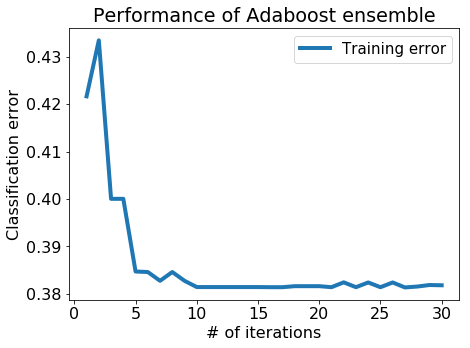

In [124]:
plt.rcParams['figure.figsize'] = 7, 5
plt.plot(range(1,31), error_all, '-', linewidth=4.0, label='Training error')
plt.title('Performance of Adaboost ensemble')
plt.xlabel('# of iterations')
plt.ylabel('Classification error')
plt.legend(loc='best', prop={'size':15})

plt.rcParams.update({'font.size': 16})

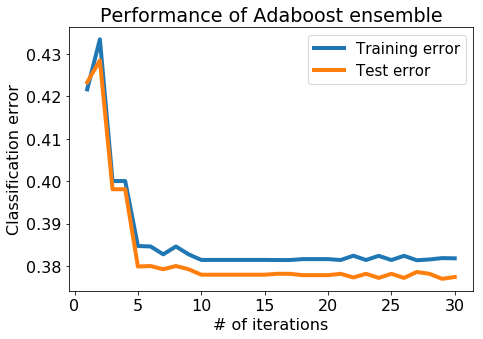

In [125]:
test_error_all = []
stump_weights, tree_stumps = boost_model_30
for n in range(1, 31):
    predictions = predict_adaboost(stump_weights[:n], tree_stumps[:n], test_data)
    error = 1.0 - accuracy(test_target, predictions)
    test_error_all.append(error)
#     print ("Iteration %s, training error = %s" % (n, error_all[n-1]))

plt.rcParams['figure.figsize'] = 7, 5
plt.plot(range(1,31), error_all, '-', linewidth=4.0, label='Training error')
plt.plot(range(1,31), test_error_all, '-', linewidth=4.0, label='Test error')

plt.title('Performance of Adaboost ensemble')
plt.xlabel('# of iterations')
plt.ylabel('Classification error')
plt.rcParams.update({'font.size': 16})
plt.legend(loc='best', prop={'size':15})
plt.tight_layout()

## Notes:

1. df.apply(func, axis=0) => default apply to eachColumn!
2. model.Predict時用不到data weights(Alpha)